# Load Library

In [1]:
# general imports
import sys
import os
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import multiprocessing as mp
import wandb

In [2]:
torch.__version__

'2.2.2'

In [3]:
# get the DGD modules (once the current version is public we can switch to the repo)
# git clone https://github.com/Center-for-Health-Data-Science/DeepGenerativeDecoder.git
# for now I added them to this repo, but the imports will stay the same
from base.dgd.nn import NB_Module
from base.dgd.DGD import DGD

# get the new stuff
from base.utils.helpers import set_seed
from base.model.decoder import Decoder
from base.data.dataset import GeneExpressionDataset
from base.engine.train import train_dgd_mirna

# Set seeds, device, and directory

In [4]:
# set random seeds, device and data directory
seed = 42
set_seed(seed)

num_workers = 14

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

datadir = "./data/"

cuda


# Load Data

In [5]:
# tcga_mrna_raw = pd.read_table("data/TCGA_mrna_counts_match_is.tsv", sep='\t', index_col=[0])
tcga_mirna = pd.read_table("data/TCGA_mirna_counts_match_iso.tsv", sep='\t', index_col=[0])

## Data Loader

In [6]:
# make data split for train and validation sets
mirna_out_dim = tcga_mirna.shape[1]-4

# shuffle the data
tcga_mirna = tcga_mirna.sample(frac=1, random_state=seed)

In [7]:
# make data split for train and validation sets
train_ratio = 0.8

# Calculate split indices
total_samples = len(tcga_mirna)
train_end = int(train_ratio * total_samples)

# Split the data
train_mrna = tcga_mirna.iloc[:train_end]
val_mrna = tcga_mirna.iloc[train_end:]

# Train, val, and test data loaders
# Default scaling_type = "mean"
train_dataset = GeneExpressionDataset(train_mrna)
validation_dataset = GeneExpressionDataset(train_mrna)

# make data loaders
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=num_workers)
validation_loader = torch.utils.data.DataLoader(validation_dataset,
                                                batch_size=128,
                                                shuffle=False,
                                                num_workers=num_workers)

In [8]:
print(train_mrna.shape)
print(val_mrna.shape)
print(mirna_out_dim)

(8540, 2454)
(2136, 2454)
2450


In [9]:
n_tissues = len(np.unique(train_dataset.label))
n_tissues

32

# Model Setup

In [10]:
# hyperparameters
latent_dim = 20
hidden_dims = [128, 512, 2048]
reduction_type = "sum" # output loss reduction

In [11]:
# decoder setup

# set up an output module for the miRNA expression data
mirna_out_fc = nn.Sequential(
    nn.Linear(hidden_dims[-1], mirna_out_dim)
    )
output_mirna_layer = NB_Module(mirna_out_fc, mirna_out_dim, scaling_type="mean")
output_mirna_layer.n_features = mirna_out_dim


# set up the decoder
decoder = Decoder(latent_dim, hidden_dims, [output_mirna_layer]).to(device)


# setup gmm init
gmm_mean_scale = 5.0 # usually between 2 and 10
sd_mean_init = 0.2 * gmm_mean_scale / n_tissues # empirically good for single-cell data at dimensionality 20

In [12]:
# init a DGD model
dgd = DGD(
        decoder=decoder,
        n_mix=n_tissues,
        rep_dim=latent_dim,
        gmm_spec={"mean_init": (gmm_mean_scale, 5.0), "sd_init": (sd_mean_init, 1.0), "weight_alpha": 1}
)

## Training loop

  0%|                                                                                                                                                                                                                                                         | 0/801 [00:00<?, ?it/s]

0 2.2274805507097453 5.311034390094409


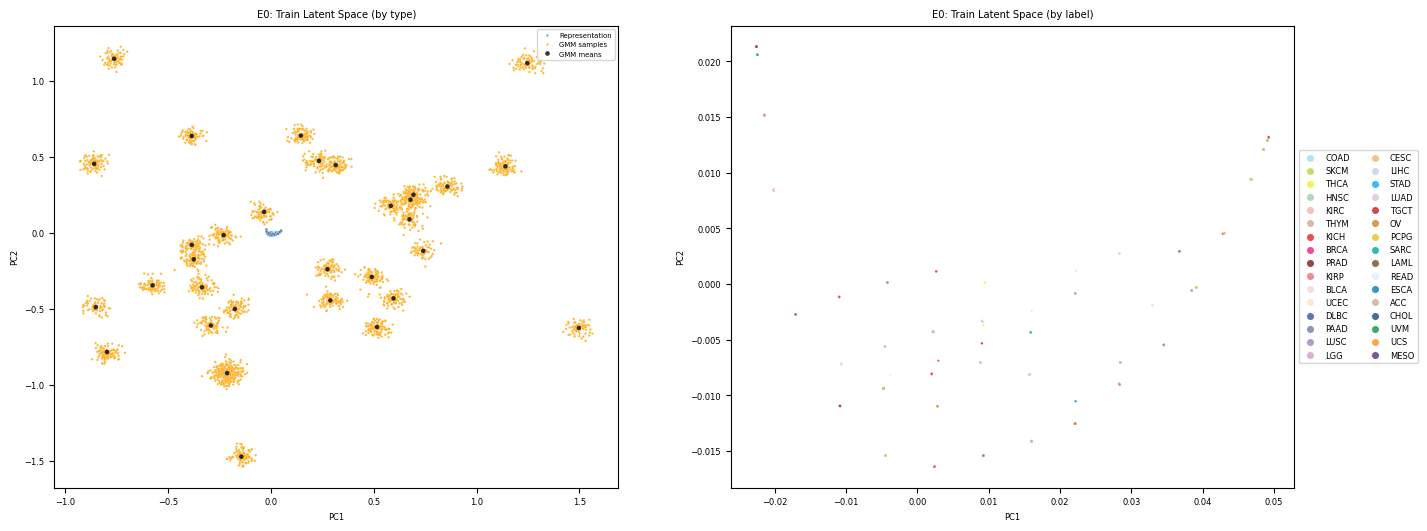

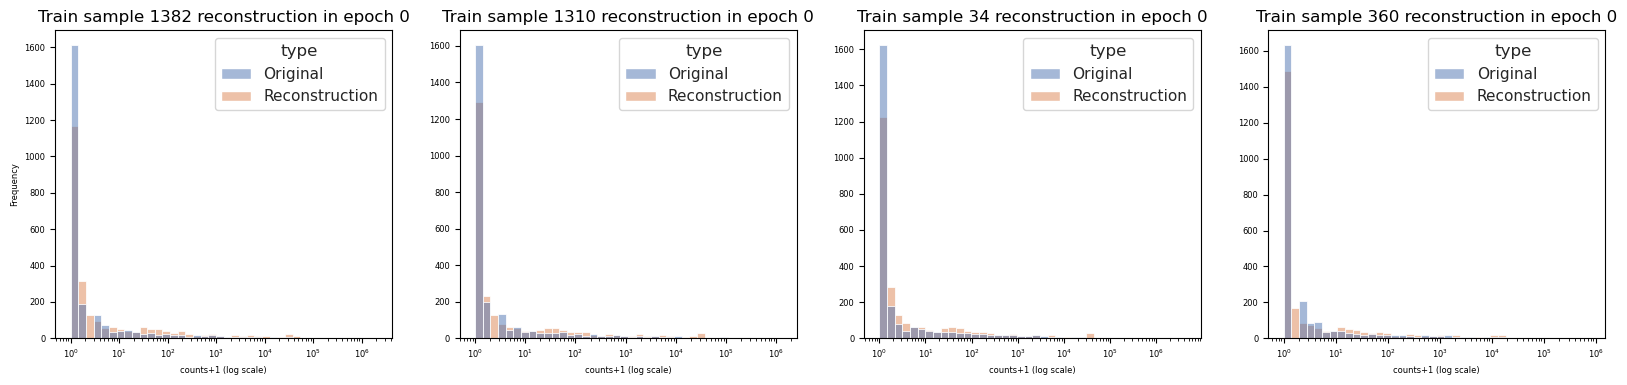

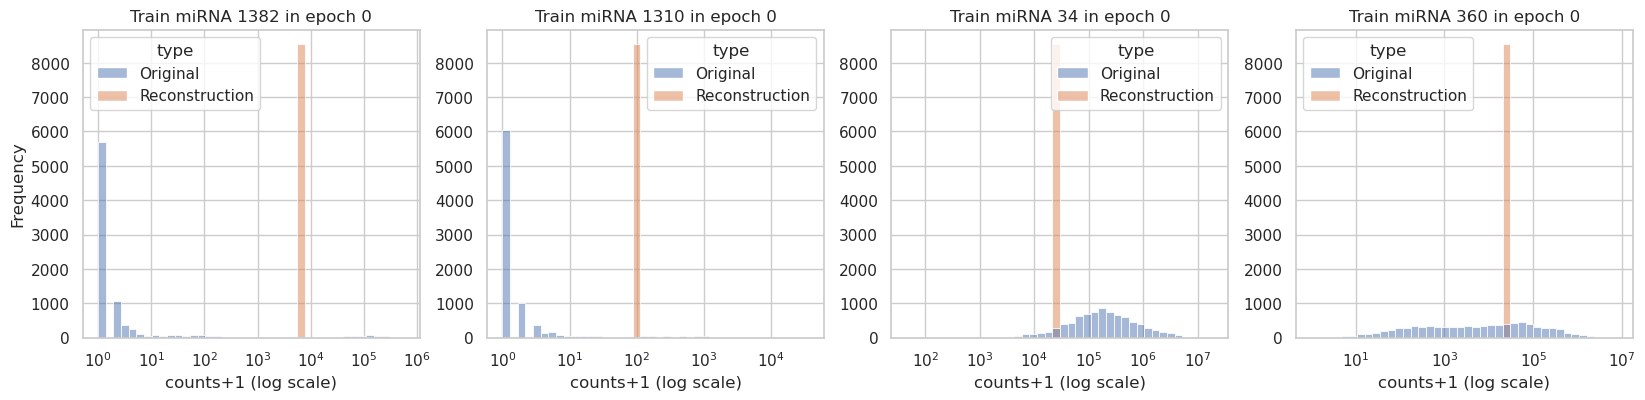

  5%|████████████▎                                                                                                                                                                                                                                   | 41/801 [01:30<25:27,  2.01s/it]

40 1.567024718611098 2.1624344222272027


 10%|████████████████████████▎                                                                                                                                                                                                                       | 81/801 [02:51<23:52,  1.99s/it]

80 1.481326036240023 2.168163327791093


 15%|████████████████████████████████████                                                                                                                                                                                                           | 121/801 [04:11<22:53,  2.02s/it]

120 1.432919327713521 2.1691310351905555


 20%|████████████████████████████████████████████████                                                                                                                                                                                               | 161/801 [05:33<21:34,  2.02s/it]

160 1.4038917399512498 2.1680532515300244


 25%|███████████████████████████████████████████████████████████▋                                                                                                                                                                                   | 200/801 [06:51<19:51,  1.98s/it]

200 1.3828774390025331 2.167842660229435


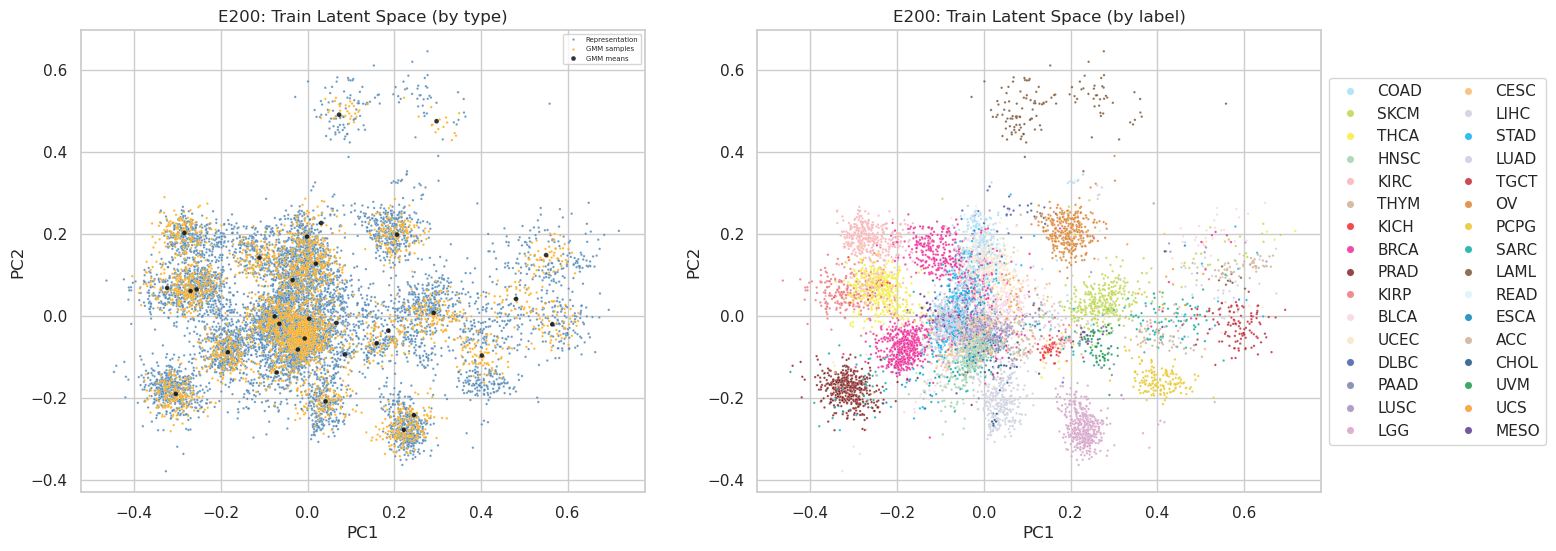

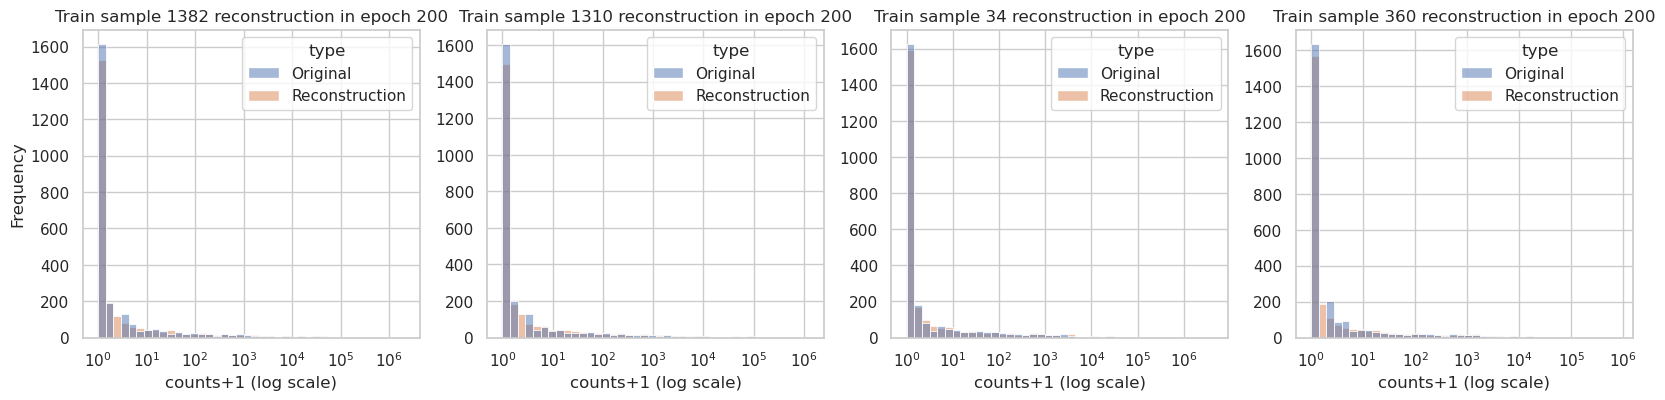

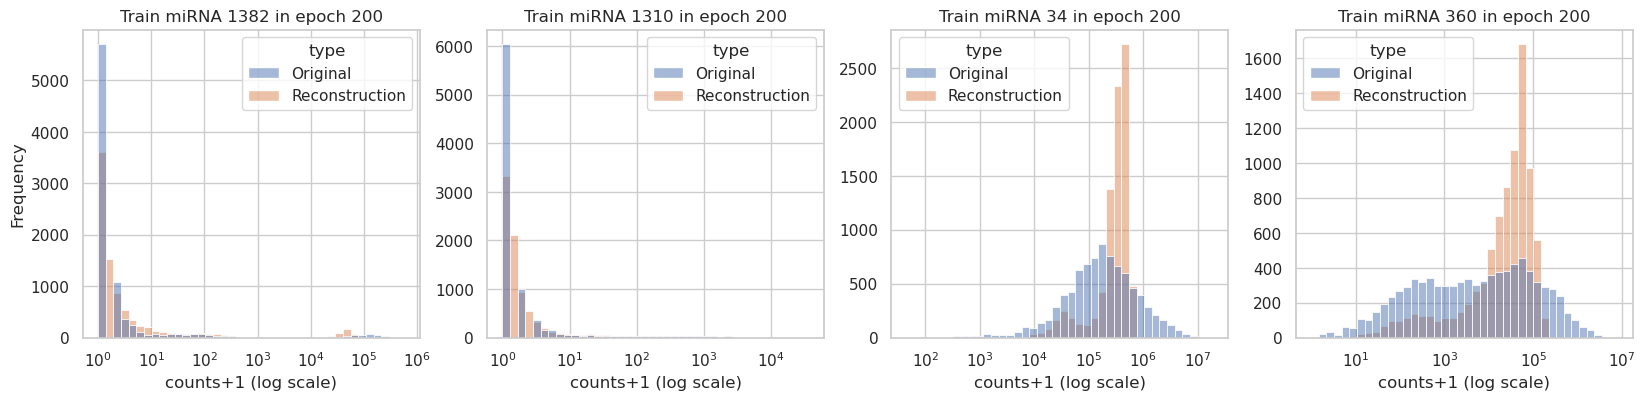

 30%|███████████████████████████████████████████████████████████████████████▉                                                                                                                                                                       | 241/801 [08:21<18:59,  2.04s/it]

240 1.3717094674520862 2.1668714479540214


 35%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                           | 281/801 [09:42<17:45,  2.05s/it]

280 1.360958386106199 2.167194775619328


 40%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                               | 321/801 [11:03<16:16,  2.03s/it]

320 1.3530981216842708 2.1665081915754905


 45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                   | 361/801 [12:25<15:01,  2.05s/it]

360 1.3565321565980022 2.166398258253897


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                       | 400/801 [13:44<13:40,  2.05s/it]

400 1.3464769153563065 2.1665734648872035


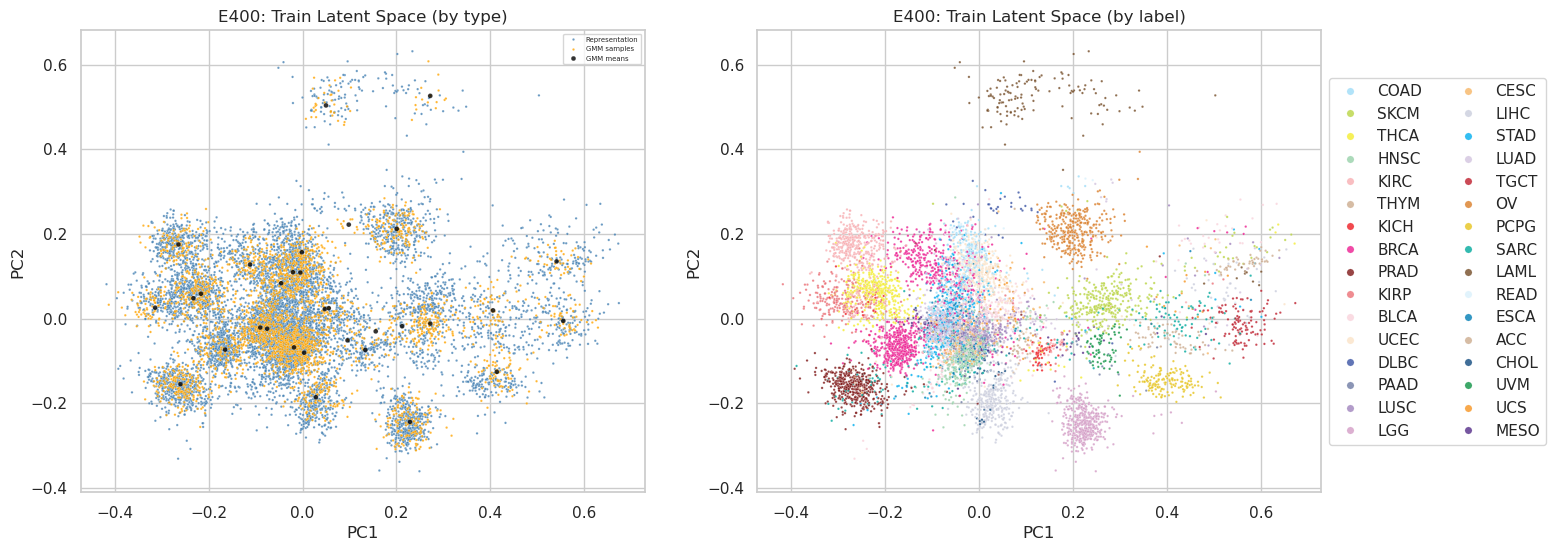

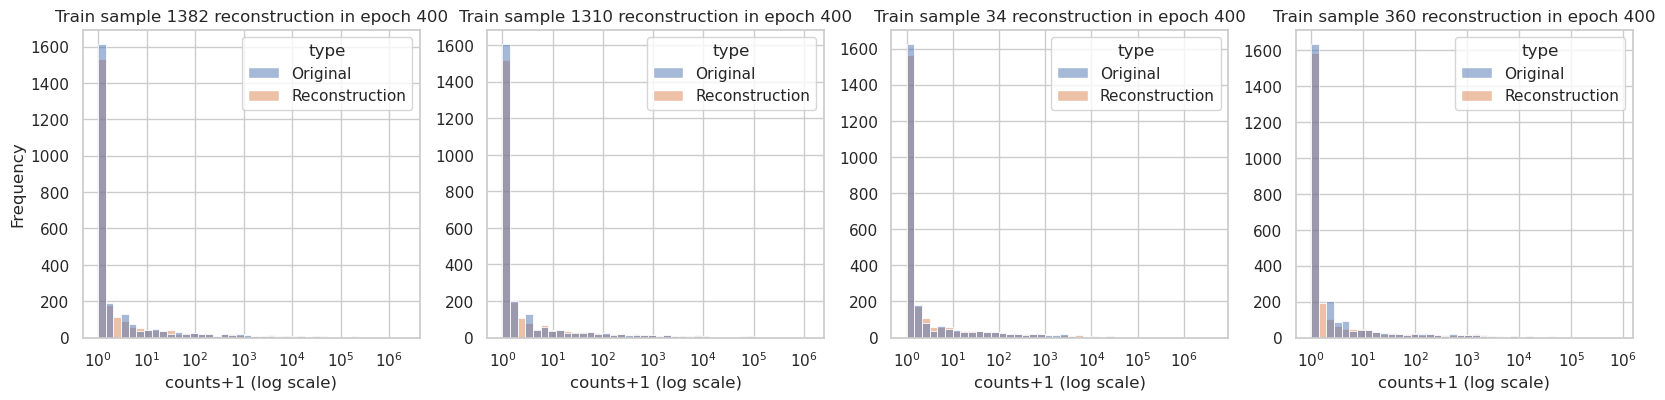

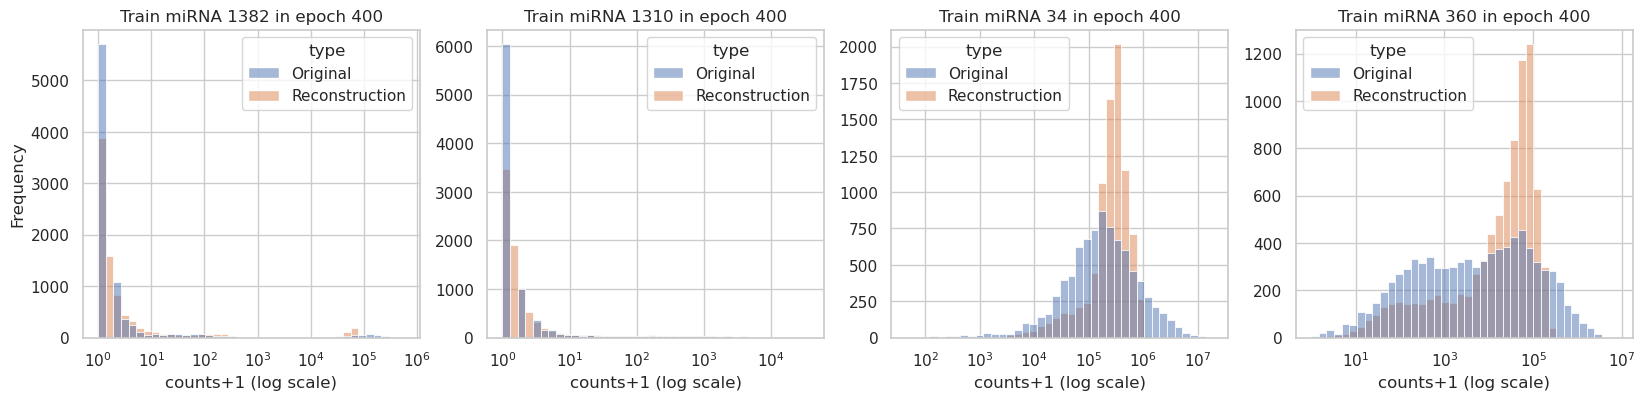

 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                           | 441/801 [15:17<12:41,  2.12s/it]

440 1.340371914280935 2.166869632622676


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                               | 481/801 [16:41<11:05,  2.08s/it]

480 1.3359284056421163 2.16682706381733


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 521/801 [18:04<09:44,  2.09s/it]

520 1.3373993556731827 2.1663466185094045


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 561/801 [19:26<08:13,  2.05s/it]

560 1.3334404662333317 2.1666818944855093


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 600/801 [20:46<06:57,  2.08s/it]

600 1.3301281603976485 2.1663165469024444


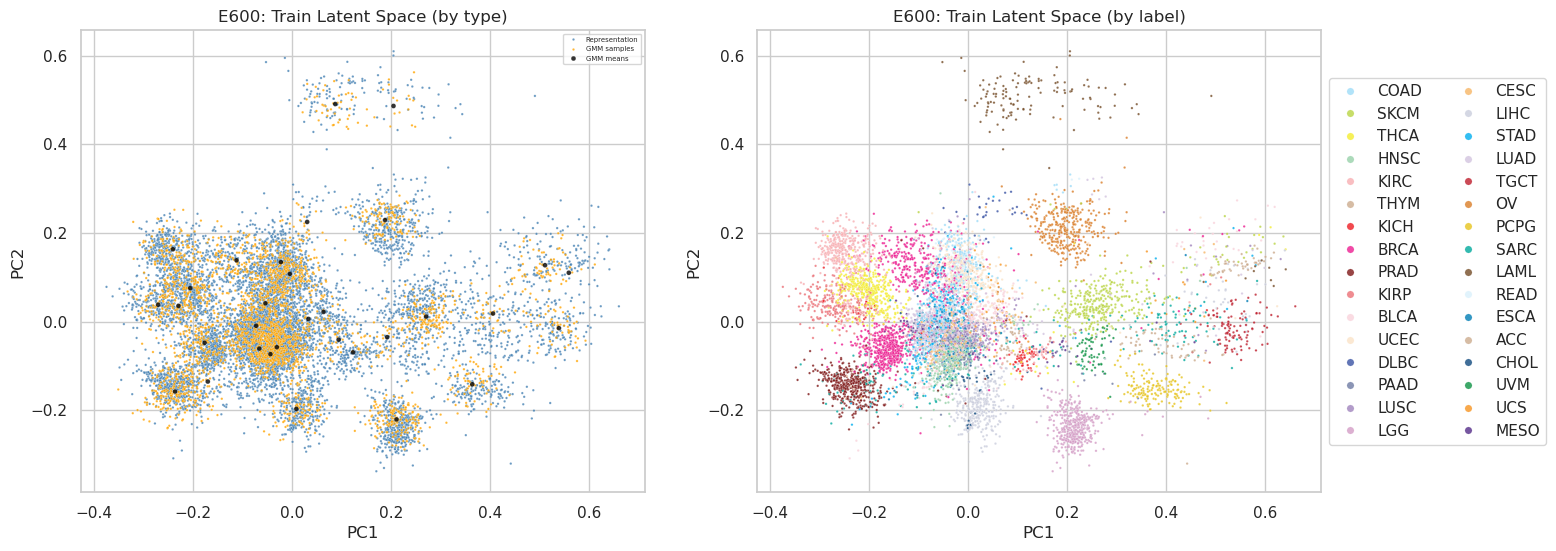

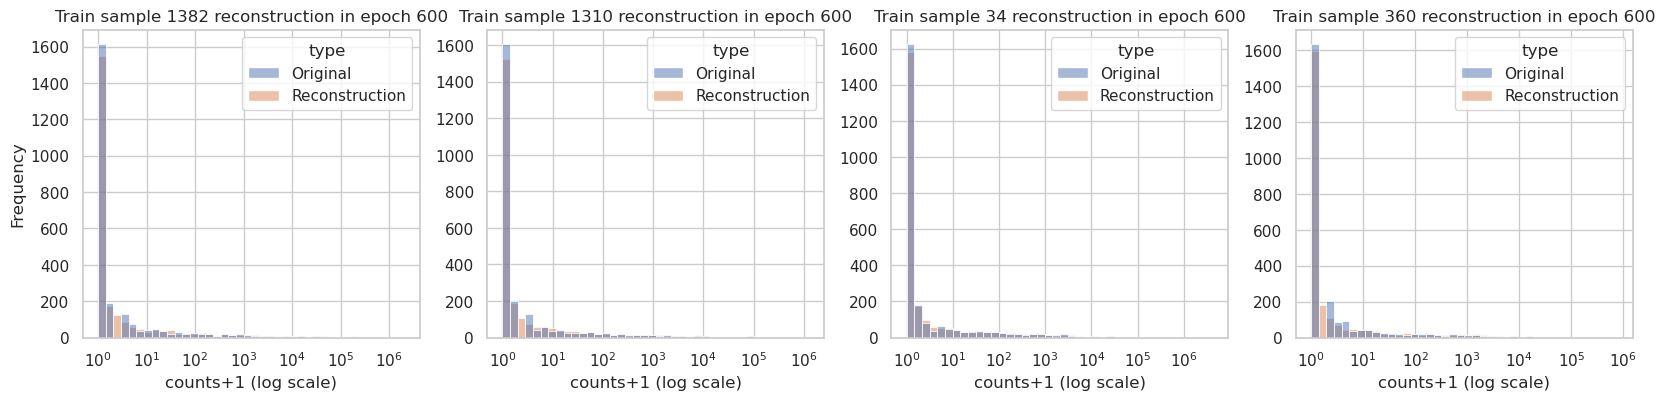

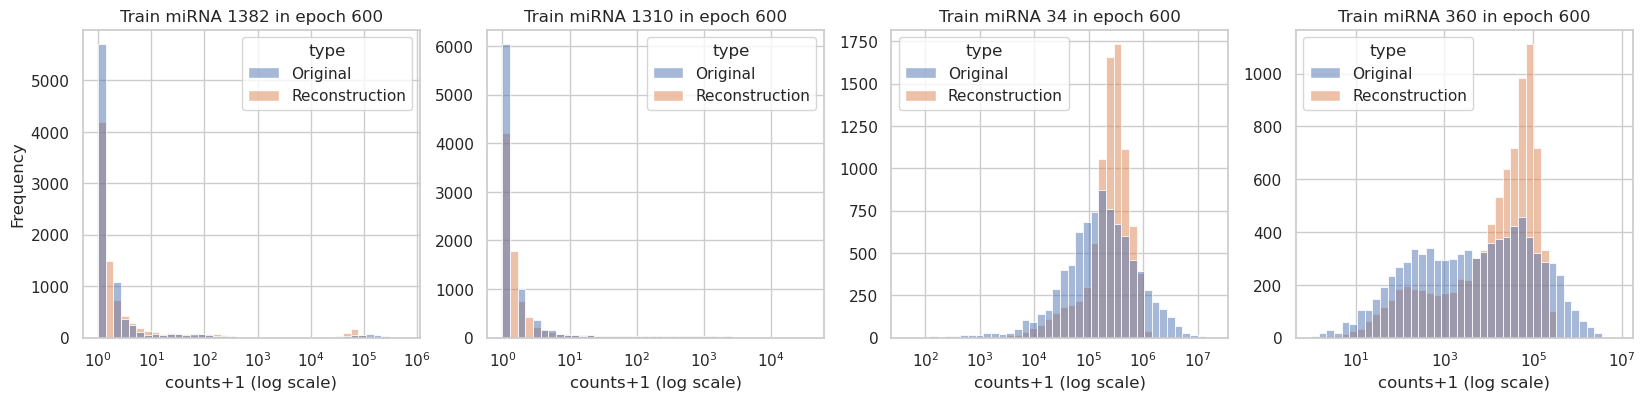

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 641/801 [22:17<05:31,  2.07s/it]

640 1.3361010879176027 2.1661411287187136


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 681/801 [23:39<04:05,  2.05s/it]

680 1.3387359215934618 2.170127136087529


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 721/801 [25:05<02:44,  2.05s/it]

720 1.3409326055656454 2.1707523133324793


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 761/801 [26:29<01:25,  2.13s/it]

760 1.325981684330641 2.167445402837749


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 800/801 [27:51<00:02,  2.09s/it]

800 1.3225036697055872 2.166565047181462


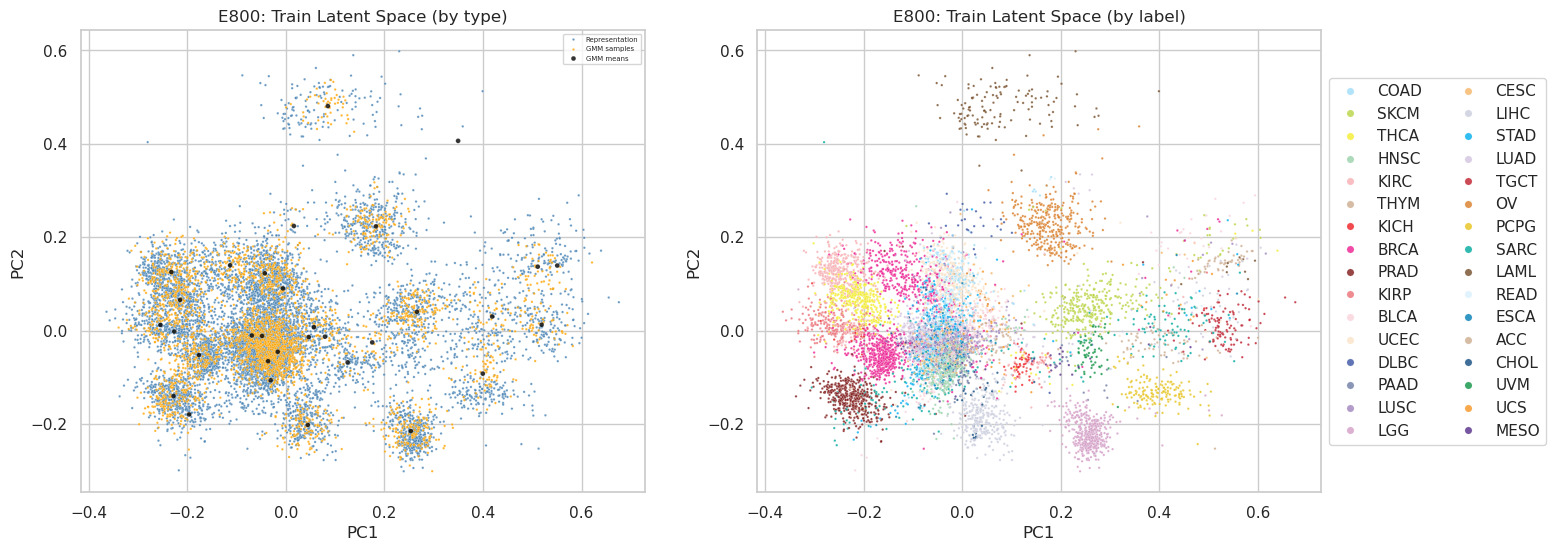

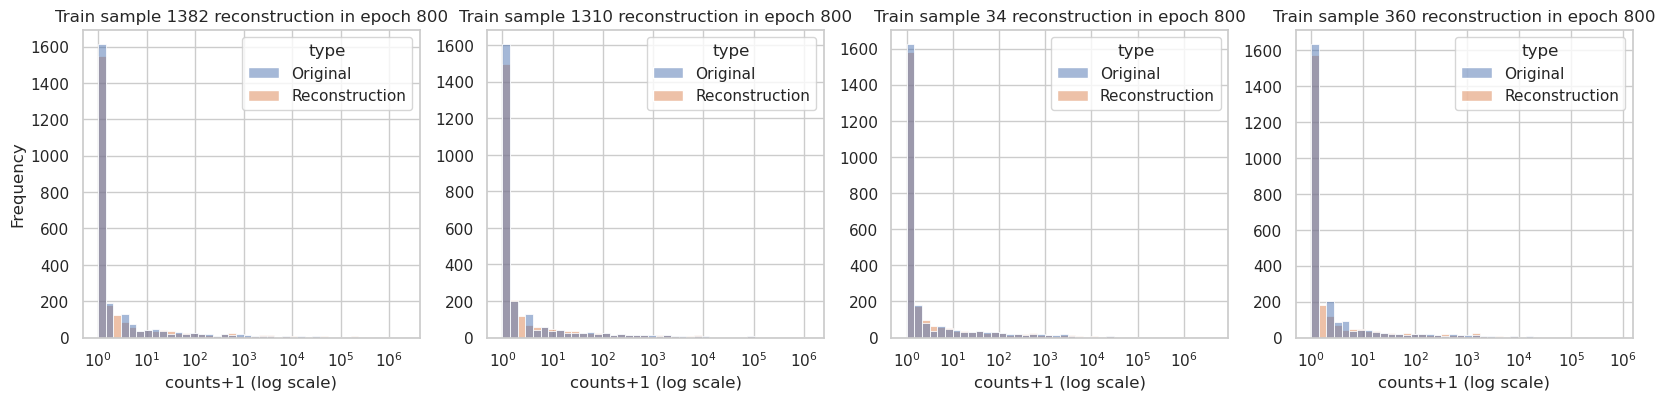

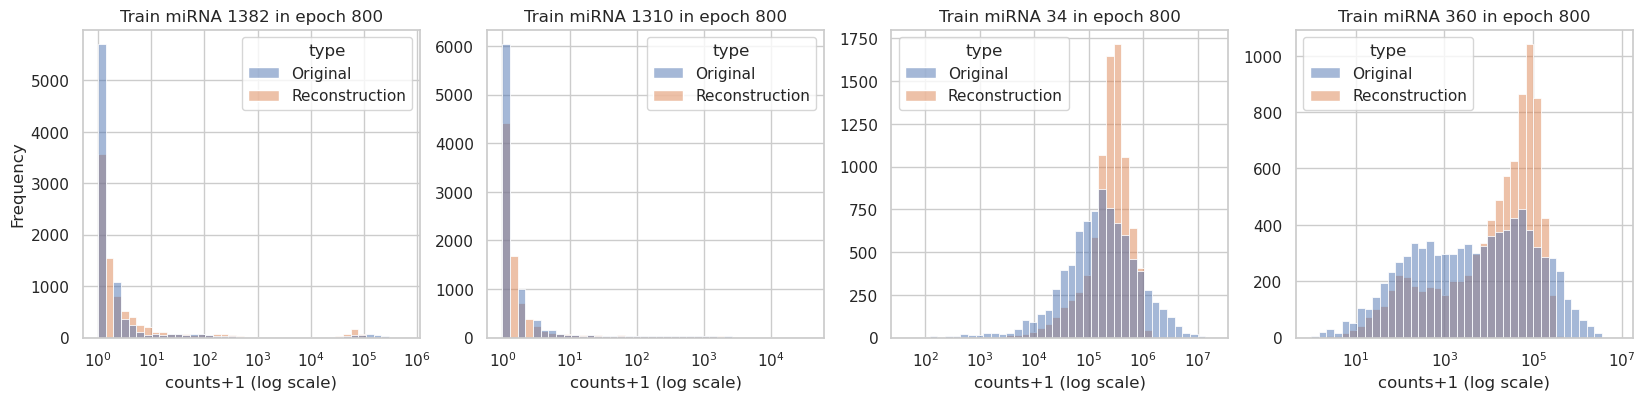

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 801/801 [27:59<00:00,  2.10s/it]


In [13]:
# train for n epochs and plot learning curves

n_epochs = 801
pr = 40 # how often to print epoch
plot = 200 # how often to print plot

loss_tab = train_dgd_mirna(
        dgd, train_loader, validation_loader, device, 
        learning_rates={'dec':0.001,'rep':0.01,'gmm':0.01},
        weight_decay=0.0001, nepochs=n_epochs, pr=pr,plot=plot, reduction_type=reduction_type,
        sample_index=[1382, 1310, 34, 360]
    )

## Save Model

In [14]:
# Set results paths
loss_path = 'results/3004_loss_mirna.pickle'
dgd_path = 'results/3004_dgd_mirna.pickle'

torch.save(loss_tab, loss_path)
torch.save(dgd, dgd_path)

# Plotting

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


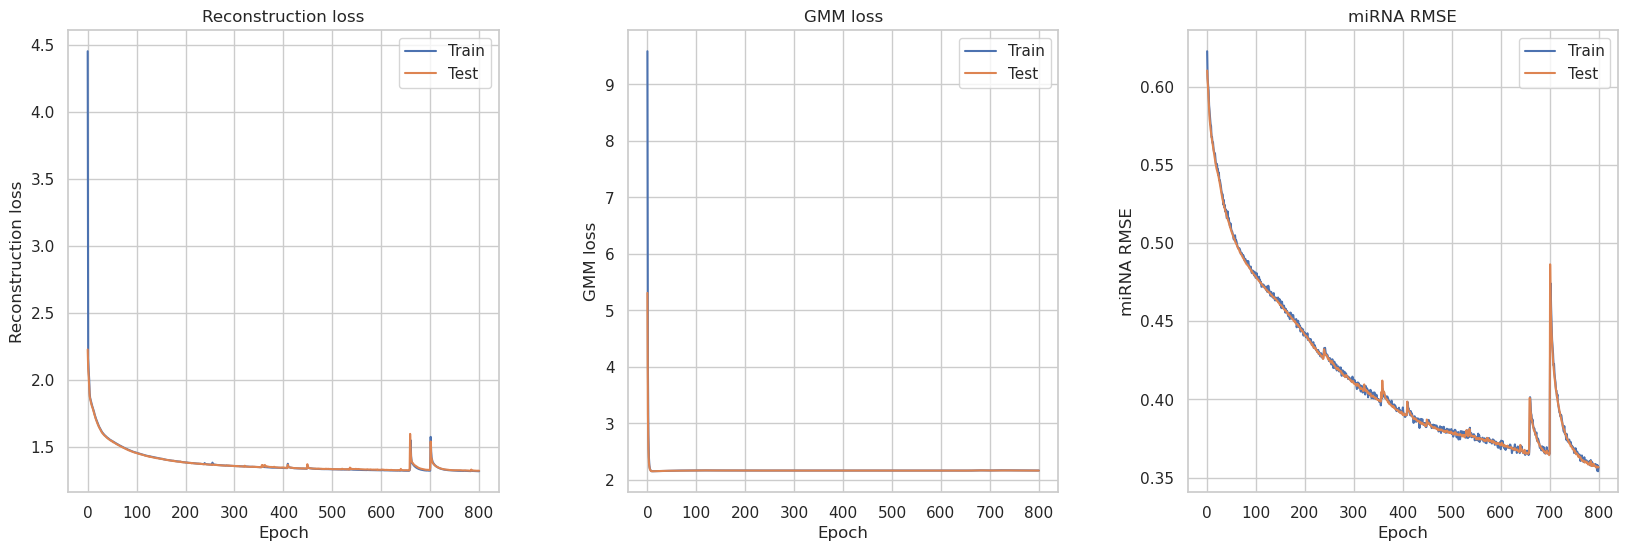

In [15]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Create a figure to hold the subplots
plt.figure(figsize=(20, 6))
plt.subplots_adjust(wspace=0.3)

# First subplot for Reconstruction loss
plt.subplot(1, 3, 1)
sns.lineplot(x="epoch", y="train_recon", data=loss_tab, label="Train")
sns.lineplot(x="epoch", y="test_recon", data=loss_tab, label="Test")
plt.title("Reconstruction loss")
plt.xlabel("Epoch")
plt.ylabel("Reconstruction loss")

# Second subplot for GMM loss
plt.subplot(1, 3, 2)
sns.lineplot(x="epoch", y="train_gmm", data=loss_tab, label="Train")
sns.lineplot(x="epoch", y="test_gmm", data=loss_tab, label="Test")
plt.title("GMM loss")
plt.xlabel("Epoch")
plt.ylabel("GMM loss")

# Third subplot for RMSE
plt.subplot(1, 3, 3)
sns.lineplot(x="epoch", y="train_rmse", data=loss_tab, label="Train")
sns.lineplot(x="epoch", y="test_rmse", data=loss_tab, label="Test")
plt.title("miRNA RMSE")
plt.xlabel("Epoch")
plt.ylabel("miRNA RMSE")

# Display the plots
plt.show()

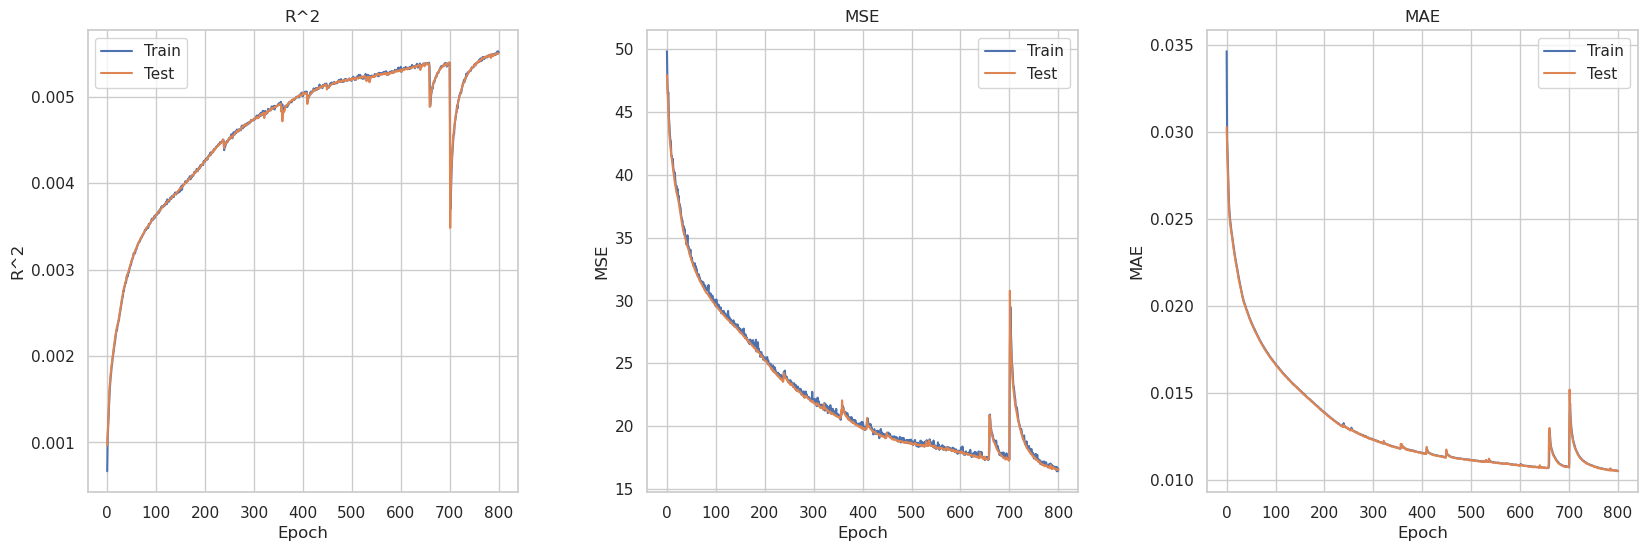

In [16]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Create a figure to hold the subplots
plt.figure(figsize=(20, 6))
plt.subplots_adjust(wspace=0.3)

# First subplot for Reconstruction loss
plt.subplot(1, 3, 1)
sns.lineplot(x="epoch", y="train_r2", data=loss_tab, label="Train")
sns.lineplot(x="epoch", y="test_r2", data=loss_tab, label="Test")
plt.title("R^2")
plt.xlabel("Epoch")
plt.ylabel("R^2")

# Second subplot for GMM loss
plt.subplot(1, 3, 2)
sns.lineplot(x="epoch", y="train_mse", data=loss_tab, label="Train")
sns.lineplot(x="epoch", y="test_mse", data=loss_tab, label="Test")
plt.title("MSE")
plt.xlabel("Epoch")
plt.ylabel("MSE")

# Third subplot for RMSE
plt.subplot(1, 3, 3)
sns.lineplot(x="epoch", y="train_mae", data=loss_tab, label="Train")
sns.lineplot(x="epoch", y="test_mae", data=loss_tab, label="Test")
plt.title("MAE")
plt.xlabel("Epoch")
plt.ylabel("MAE")

# Display the plots
plt.show()